In [1]:
# Mount Google Drive for file access
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install xmltodict tensorflow efficientnet


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [3]:
# Importing all the libraries
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Setting up paths and constants
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = '/content/drive/MyDrive/content/all_images/'
SAVE_MODEL_DIR = '/content/drive/MyDrive/content/saved_model/'

# Path of drectories for positive, negative and XML images
image_dir = '/content/drive/MyDrive/content/tb_positive/'
xml_dir = '/content/drive/MyDrive/content/tb_xml/'
bbox_save_dir = '/content/drive/MyDrive/content/tb_images_bbox/'
negative_dir = '/content/drive/MyDrive/content/tb_negative_augmented/'


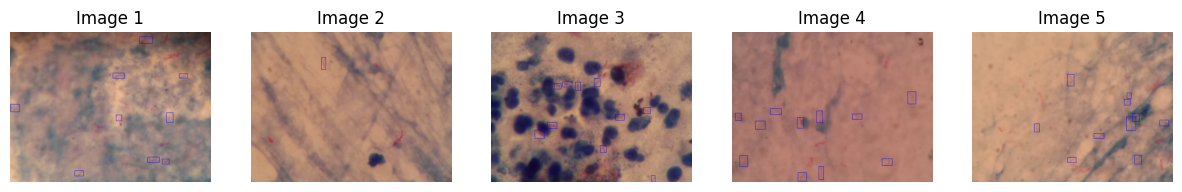

In [14]:
import xml.etree.ElementTree as ET
# Extracting bounding boxes from XML files
def extract_boxes_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for member in root.findall('object'):
        bndbox = member.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
    return boxes

# Saving the images containing bounding boxes
def save_image_with_boxes(image_path, boxes, save_dir):
    image = cv2.imread(image_path)
    for box in boxes:
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, os.path.basename(image_path))
    cv2.imwrite(save_path, image)
    return save_path  # Return the saved image path

# Image processing and extraction of bounding boxes from XML
saved_images = []  # Initialize the list to hold saved image paths
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        image_file = os.path.join(image_dir, filename)
        xml_file = os.path.join(xml_dir, filename.replace('.jpg', '.xml'))
        if os.path.exists(xml_file):
            boxes = extract_boxes_from_xml(xml_file)
            saved_image_path = save_image_with_boxes(image_file, boxes, bbox_save_dir)
            saved_images.append(saved_image_path)  # Append the saved image path

# Displaying 5 images sample with bounding boxes
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(saved_images[:5]):  # Displaying first 5 images
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color representation
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title(f"Image {i + 1}")  # Optional title

plt.show()

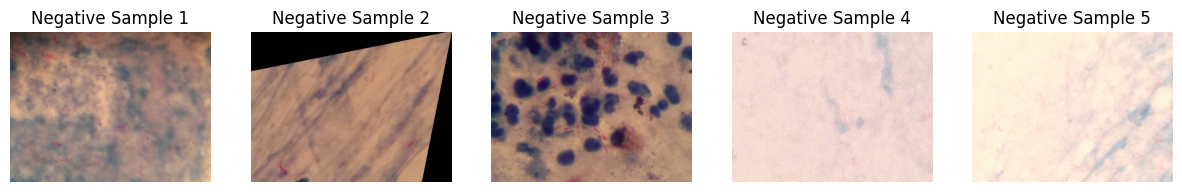

In [15]:
# Applying multiple augmentation techniques for generating negative images

def add_gaussian_noise(image):
    noise = np.random.normal(0, 10, image.shape).astype(np.uint8)
    return cv2.add(image, noise)

# Randomly applying any 3 augmentation techniques from all the other
def advanced_augmentation(image):
    augmentations = [
        lambda x: cv2.flip(x, 1),
        lambda x: cv2.GaussianBlur(x, (5, 5), 0),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
        lambda x: cv2.resize(x, None, fx=1.2, fy=1.2),
        lambda x: cv2.rotate(x, cv2.ROTATE_180),
        lambda x: cv2.resize(x, None, fx=0.8, fy=0.8),
        lambda x: cv2.convertScaleAbs(x, alpha=1.2, beta=30),
        lambda x: cv2.warpAffine(x, np.float32([[1, 0.2, 0], [0.2, 1, 0]]), (x.shape[1], x.shape[0])),
        add_gaussian_noise,
    ]
    random.shuffle(augmentations)
    for augment in random.sample(augmentations, 3):
        image = augment(image)
    return image

# Negative samples generated and saved
counter = 0
negative_images = []  # List to hold paths of negative images
os.makedirs(negative_dir, exist_ok=True)
for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    image = cv2.imread(img_path)
    if image is not None:
        augmented_image = advanced_augmentation(image)
        negative_image_path = os.path.join(negative_dir, f'neg_{counter}.jpg')
        cv2.imwrite(negative_image_path, augmented_image)
        negative_images.append(negative_image_path)  # Append the path of the saved image
        counter += 1
        if counter >= 1500:
            break

# Displaying 5 negative samples
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(negative_images[:5]):  # Display the first 5 negative images
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color representation
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title(f"Negative Sample {i + 1}")  # Optional title

plt.show()


In [6]:
# Setting up folder in google drive with both positive and negative images
import shutil
def copy_images(src_dir, dst_dir, prefix):
    os.makedirs(dst_dir, exist_ok=True)
    for counter, filename in enumerate(os.listdir(src_dir)):
        if filename.endswith('.jpg'):
            src_path = os.path.join(src_dir, filename)
            dst_path = os.path.join(dst_dir, f"{prefix}_{counter}.jpg")
            shutil.copy(src_path, dst_path)

copy_images(bbox_save_dir, DATA_DIR, 'bbox')
copy_images(negative_dir, DATA_DIR, 'neg')
print("All images successfully copied to the 'all_images' folder.")


All images successfully copied to the 'all_images' folder.


In [5]:
# Count of positive and negative samples
def is_positive_image(image_path):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 150, 0])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
    return np.sum(mask) > 1000

def load_images_and_labels(directory):
    images, labels = [], []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH)) / 255.0
            label = 1 if is_positive_image(image_path) else 0
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(DATA_DIR)
print(f"Positive samples: {np.sum(labels)}, Negative samples: {len(labels) - np.sum(labels)}")

# Oversampling og negative sample for handling class imbalance
pos_count, neg_count = np.sum(labels), len(labels) - np.sum(labels)
if neg_count < pos_count:
    neg_indices = np.where(labels == 0)[0]
    additional_indices = np.random.choice(neg_indices, pos_count - neg_count, replace=True)
    images = np.concatenate((images, images[additional_indices]))
    labels = np.concatenate((labels, labels[additional_indices]))

print(f"Total samples after oversampling: {len(labels)}")



Positive samples: 2141, Negative samples: 370
Total samples after oversampling: 4282


In [6]:
# Count for positive and negative samples after oversampling
final_pos_count = np.sum(labels)
final_neg_count = len(labels) - final_pos_count
print(f"Final Positive samples: {final_pos_count}, Final Negative samples: {final_neg_count}")

Final Positive samples: 2141, Final Negative samples: 2141


In [7]:
# Training MobileNetV2 model

# Splitting the data into test and train
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).shuffle(1000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)

# Building model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize and train MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False
model = build_model(base_model)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)
model.save(os.path.join(SAVE_MODEL_DIR, 'mobilenetv2_tb_classifier.h5'))

# Evaluation of the Model
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
108/108 [==============================] - 32s 272ms/step - loss: 0.2736 - accuracy: 0.8815 - val_loss: 0.2299 - val_accuracy: 0.9032
Epoch 2/10
108/108 [==============================] - 28s 258ms/step - loss: 0.1872 - accuracy: 0.9282 - val_loss: 0.2044 - val_accuracy: 0.9265
Epoch 3/10
108/108 [==============================] - 28s 258ms/step - loss: 0.1444 - accuracy: 0.9466 - val_loss: 0.1888 - val_accuracy: 0.9323
Epoch 4/10
108/108 [==============================] - 27s 252ms/step - loss: 0.1224 - accuracy: 0.9588 - val_loss: 0.1678 - val_accuracy: 0.9405
Epoch 5/10
108/108 [==============================] - 28s 256ms/step - loss: 0.1037 - accuracy: 0.9693 - val_loss: 0.1736 - val_accuracy: 0.9393
Epoch 6/10
108/108 [==============================] - 28s 255ms/step - loss: 0.0936 - accuracy: 0.9696 - val_loss: 0.1536 - val_accuracy: 0.9452
Epoch 7/10
108/108 [==============================] - 28s 257ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 6s 209ms/step - loss: 0.1479 - accuracy: 0.9568
Validation accuracy: 95.68%


27/27 [==============================] - 7s 204ms/step
              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96       395
    Positive       1.00      0.92      0.96       462

    accuracy                           0.96       857
   macro avg       0.96      0.96      0.96       857
weighted avg       0.96      0.96      0.96       857



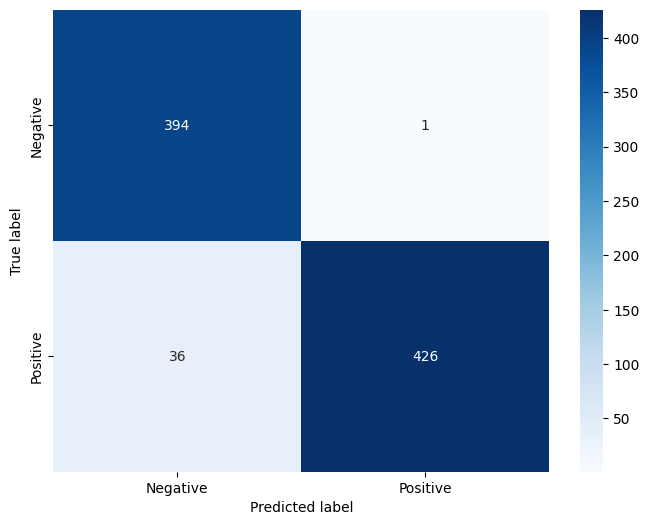

In [8]:
# Visualization


# Plotting of Confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Generating Classification Report
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'])
    print(report)

y_pred_prob = model.predict(val_dataset)
y_pred = (y_pred_prob > 0.5).astype("int32")
print_classification_report(y_val, y_pred)
plot_confusion_matrix(y_val, y_pred)


In [9]:
# Training DenseNet121 model

from tensorflow.keras.applications import DenseNet121

# Building the DenseNet121 model
def build_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False  # Freeze the base model layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
densenet_model = build_densenet_model()

# Training
densenet_history = densenet_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)
densenet_model.save(os.path.join(SAVE_MODEL_DIR, 'densenet121_tb_classifier.h5'))

# Evaluation
densenet_val_loss, densenet_val_accuracy = densenet_model.evaluate(val_dataset)
print(f"DenseNet121 Validation accuracy: {densenet_val_accuracy * 100:.2f}%")


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
108/108 [==============================] - 89s 767ms/step - loss: 0.2891 - accuracy: 0.8739 - val_loss: 0.2490 - val_accuracy: 0.8891
Epoch 2/10
108/108 [==============================] - 77s 709ms/step - loss: 0.2140 - accuracy: 0.9142 - val_loss: 0.2559 - val_accuracy: 0.8868
Epoch 3/10
108/108 [==============================] - 78s 717ms/step - loss: 0.1844 - accuracy: 0.9308 - val_loss: 0.2496 - val_accuracy: 0.8891
Epoch 4/10
108/108 [==============================] - 74s 687ms/step - loss: 0.1562 - accuracy: 0.9439 - val_loss: 0.1899 - val_accuracy: 0.9090
Epoch 5/10
108/108 [==============================] - 74s 687ms/step - loss: 0.1462 - accuracy: 0.9472 - val_loss: 0.1946 - val_accuracy: 0.9043
Epoch 6/10
108/108 [==============================] - 73s 678ms/step - loss: 0.1360 - accuracy: 0.9498 - val_loss: 0.1519 - val_accuracy: 0.9370
Epoch 7/10
108/108 [==============================] - 70s 645ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 13s 496ms/step - loss: 0.1065 - accuracy: 0.9650
DenseNet121 Validation accuracy: 96.50%


27/27 [==============================] - 16s 536ms/step
Classification report for DenseNet121:
              precision    recall  f1-score   support

    Negative       0.95      0.97      0.96       395
    Positive       0.98      0.96      0.97       462

    accuracy                           0.96       857
   macro avg       0.96      0.97      0.96       857
weighted avg       0.97      0.96      0.97       857

Confusion matrix for DenseNet121:


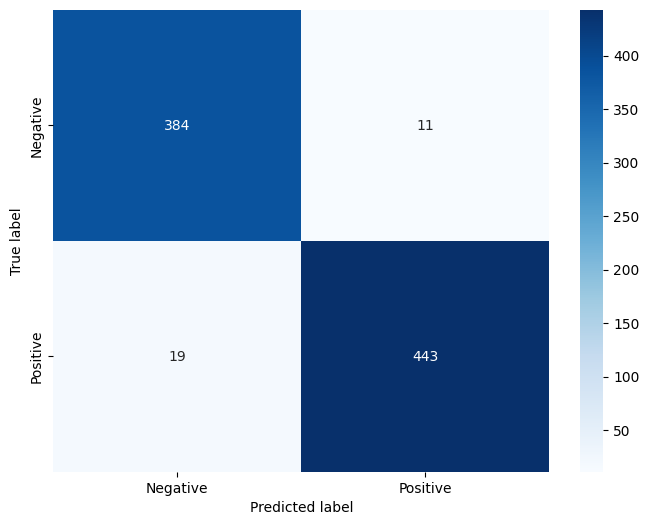

In [10]:
# Prediction on the model
densenet_y_pred_prob = densenet_model.predict(val_dataset)
densenet_y_pred = (densenet_y_pred_prob > 0.5).astype("int32")

# Generating classification report
print("Classification report for DenseNet121:")
print_classification_report(y_val, densenet_y_pred)

# Plotting confusion matrix
print("Confusion matrix for DenseNet121:")
plot_confusion_matrix(y_val, densenet_y_pred)
